In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import os
import re

# Leer datos Indices de Rezago Social

In [2]:
folders_IRS = os.listdir("data/")
folders_IRS = ["data/"+i for i in folders_IRS if "IRS" in i]
folders_IRS

['data/IRS_localidades_2000.xlsx',
 'data/IRS_localidades_2005.xlsx',
 'data/IRS_localidades_2010.xlsx',
 'data/IRS_localidades_2020.xlsx']

In [3]:
rename_columns = {
    "Indicadores de rezago social (porcentaje)":np.NaN,
    "Entidad \nfederativa":"Entidad federativa",
    "Población \ntotal":"Población total",
}

In [4]:
def loadISR(folders_IRS):
    ISR_full = pd.DataFrame()
    colnames = []

    for folder in folders_IRS:
        ISR_df = pd.ExcelFile(folder)
        year = folder[:-5].split("_")[-1]
        for sheet in ISR_df.sheet_names:
            ISR_sheet = ISR_df.parse(sheet, skiprows=4)
            ISR_sheet.replace(rename_columns, inplace=True)
            ISR_sheet[:2] = ISR_sheet[:2].fillna(method="bfill")

            ISR_sheet.columns = ISR_sheet.iloc[0]
            ISR_sheet.drop(ISR_sheet.index[0], inplace=True)
            ISR_sheet.dropna(subset="Localidad", inplace=True)
            ISR_sheet.dropna(how="all", axis=1, inplace=True)
            ISR_sheet["year"] = year

            ISR_full = pd.concat([ISR_full, ISR_sheet], ignore_index=True)
            colnames.append(ISR_sheet.columns)

    return ISR_full
#ISR_full = loadISR(folders_IRS)
#ISR_full.to_csv("data/ISR_full.csv",index=False)
ISR_full = pd.read_csv("data/ISR_full.csv")
ISR_full.info()
ISR_full

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423467 entries, 0 to 423466
Data columns (total 22 columns):
 #   Column                                                                                                 Non-Null Count   Dtype  
---  ------                                                                                                 --------------   -----  
 0   Clave localidad                                                                                        423467 non-null  int64  
 1   Entidad federativa                                                                                     423467 non-null  object 
 2   Municipio                                                                                              423467 non-null  object 
 3   Localidad                                                                                              423467 non-null  object 
 4   Población total                                                                       

,Clave localidad,Entidad federativa,Municipio,Localidad,Población total,Población de 15 años o más analfabeta,Población de 6 a 14 años que no asiste a la escuela,Población de 15 años y más con educación básica incompleta,Población sin derechohabiencia a servicios de salud,Viviendas con piso de tierra,...,Viviendas que no disponen de drenaje,Viviendas que no disponen de energía eléctrica,Viviendas que no disponen de lavadora,Viviendas que no disponen de refrigerador,Índice de rezago social,Grado de rezago social,Lugar que ocupa en el contexto nacional,year,"Hogares con población de 15 a 29 años, con algún habitante con menos de 9 años de educación aprobados",Promedio de ocupantes por cuarto
0,10010001,AGUASCALIENTES,AGUASCALIENTES,AGUASCALIENTES,594092,3.407850,5.145010,40.869800,34.093040,1.909650,...,0.979540,0.762040,17.940530,10.573430,-2.447551,Muy bajo,106455.0,2000,NaN,NaN
1,10010096,AGUASCALIENTES,AGUASCALIENTES,AGUA AZUL,79,20.833330,5.882350,85.416670,53.164560,6.666670,...,73.333330,13.333330,53.333340,33.333330,-0.599735,Bajo,77208.0,2000,NaN,NaN
2,10010106,AGUASCALIENTES,AGUASCALIENTES,ARELLANO,1059,8.681130,11.153850,69.282140,47.780930,7.462690,...,5.472640,2.985070,41.293530,27.363180,-1.752400,Muy bajo,102049.0,2000,NaN,NaN
3,10010112,AGUASCALIENTES,AGUASCALIENTES,BAJIO LOS VAZQUEZ,69,12.000000,0.000000,82.000000,89.855070,0.000000,...,50.000000,0.000000,33.333330,25.000000,-1.364606,Bajo,95650.0,2000,NaN,NaN
4,10010120,AGUASCALIENTES,AGUASCALIENTES,BUENAVISTA DE PEÑUELAS,588,16.164380,6.569340,72.602740,27.551020,0.862070,...,13.793100,0.000000,35.344830,16.379310,-1.861600,Muy bajo,103293.0,2000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423462,320580030,Zacatecas,Santa María de la Paz,Las Tablas,34,12.000000,0.000000,56.000000,0.000000,7.692308,...,38.461538,0.000000,30.769231,23.076923,-0.375147,Bajo,59280.0,2020,NaN,NaN
423463,320580033,Zacatecas,Santa María de la Paz,Los Horcones,12,16.666667,0.000000,100.000000,16.666667,28.571429,...,57.142857,0.000000,28.571429,28.571429,0.192058,Medio,34484.0,2020,NaN,NaN
423464,320580035,Zacatecas,Santa María de la Paz,Los Trigos (Mesa de los Trigos),89,4.411765,0.000000,55.882353,15.730337,4.347826,...,13.043478,4.347826,21.739130,8.695652,-0.628247,Bajo,75373.0,2020,NaN,NaN
423465,320580037,Zacatecas,Santa María de la Paz,Mesa Grande,165,2.400000,3.571429,60.000000,10.303030,8.163265,...,20.408163,0.000000,12.244898,0.000000,-0.806189,Bajo,87671.0,2020,NaN,NaN


# Datos DAYMET

In [5]:
daymet_root = "data/daymet/"
list_daymet = os.listdir(daymet_root)
list_daymet = [daymet_root+i for i in list_daymet]
print(len(list_daymet))
list_daymet[:5]

7665


['data/daymet/2000-01-01.csv',
 'data/daymet/2000-01-02.csv',
 'data/daymet/2000-01-03.csv',
 'data/daymet/2000-01-04.csv',
 'data/daymet/2000-01-05.csv']

In [6]:
def read_daymet(dirs):
    df_final = pd.DataFrame(columns=[
        'tmax', 'tmin', 'NOMGEO', 'CVE_ENT', 'date'
    ])
    for dir in dirs:
        df = pd.read_csv(dir)
        date = dir[12:-4]
        df["date"] = date

        df.drop(columns=["CVEGEO", "system:index",'dayl',
                         'prcp', 'srad', 'swe','vp'],
                inplace=True)

        df_final = pd.concat([df_final, df])

    df_final["date"] = pd.to_datetime(df_final["date"],
                                      infer_datetime_format=True)
    df_final["week_index"] = df_final.date.dt.week
    df_final["year"] = df_final.date.dt.year
    df_final = df_final.groupby(by=["NOMGEO", "year", "week_index"],
                                as_index=False).mean()
    df_final.rename(columns={"NOMGEO":"estado"}, inplace=True)

    return df_final

#df_daymet = read_daymet(list_daymet)
#df_daymet.to_csv("data/daymet_full.csv",index=False)
df_daymet = pd.read_csv("data/daymet_full.csv")
df_daymet

,estado,year,week_index,tmax,tmin,CVE_ENT,date
0,Aguascalientes,2000,1,22.647606,1.195663,1.0,2000-01-06 00:00:00
1,Aguascalientes,2000,2,22.635875,2.480746,1.0,2000-01-13 00:00:00
2,Aguascalientes,2000,3,22.363806,0.680293,1.0,2000-01-20 00:00:00
3,Aguascalientes,2000,4,23.790566,1.858065,1.0,2000-01-27 00:00:00
4,Aguascalientes,2000,5,22.275614,1.152001,1.0,2000-02-03 00:00:00
...,...,...,...,...,...,...,...
35163,Zacatecas,2020,49,21.006084,2.734376,32.0,2020-12-03 00:00:00
35164,Zacatecas,2020,50,22.240216,5.068265,32.0,2020-12-10 00:00:00
35165,Zacatecas,2020,51,23.080537,3.146933,32.0,2020-12-17 00:00:00
35166,Zacatecas,2020,52,22.002875,2.286106,32.0,2020-12-24 00:00:00


# Leer datos dengue

In [13]:
dengue_sheets = pd.ExcelFile("data/dengue-climate.xlsx")

In [50]:
def groupdenguedata(sheets, excelfile):
    dfDengue = pd.DataFrame()

    for sheet in sheets:

        dfi = excelfile.parse(sheet, skiprows=2)
        dfi = dfi[dfi["id"] < 33]
        dfi.drop(columns=["id"], inplace=True)

        dfiMelted = dfi.melt(id_vars=["estado","year"], var_name="semana", value_name="casos")
        dfiMelted["year"] = dfiMelted["year"].astype(int)

        dfiMelted["clase"] = [re.split(pattern="_\d", string=i)[0] for i in dfiMelted["semana"]]
        dfiMelted["week"]  = [re.split(pattern="_", string=i)[-1] for i in dfiMelted["semana"]]

        dict_clases = {
            "clas":"Dengue clásico",
            "h_e":"Dengue hemorrágico (en estudio)",
            "h_c":"Dengue hemorrágico (confirmado)",
            " ":0,
            "-":0,
            "-----":0
        }
        dfiMelted.replace(dict_clases, inplace=True)

        dfiMelted["date"] = dfiMelted["year"].astype(str) + "-" +dfiMelted["week"]+"-1"
        dfiMelted["date"] = pd.to_datetime(dfiMelted["date"], format="%Y-%W-%w")


        dfDengue = pd.concat([dfDengue, dfiMelted])
    dfDengue["casos"].replace({
        "-":np.NaN,
        "n.e.":np.NaN,
        "n.e. ":np.NaN,
        "n.d ":np.NaN,
        "-----":np.NaN,
        " ":np.NaN,
        'n.e':np.NaN
        }, inplace=True)

    dfDengue["casos"].fillna(0, inplace=True)
    dfDengue["casos"] = dfDengue["casos"].astype(int)
    return dfDengue

In [7]:
#dfDengue = groupdenguedata(dengue_sheets.sheet_names, dengue_sheets)
#dfDengue.to_csv("dengue_full.csv", index=False)

dfDengue = pd.read_csv("data/dengue_full.csv")
dfDengue.info()
dfDengue

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99840 entries, 0 to 99839
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   estado  99840 non-null  object
 1   year    99840 non-null  int64 
 2   semana  99840 non-null  object
 3   casos   99840 non-null  int64 
 4   clase   99840 non-null  object
 5   week    99840 non-null  int64 
 6   date    99840 non-null  object
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


,estado,year,semana,casos,clase,week,date
0,Aguascalientes,2002,clas_1,0,Dengue clásico,1,2002-01-07
1,Baja California,2002,clas_1,0,Dengue clásico,1,2002-01-07
2,Baja California Sur,2002,clas_1,0,Dengue clásico,1,2002-01-07
3,Campeche,2002,clas_1,3,Dengue clásico,1,2002-01-07
4,Coahuila,2002,clas_1,0,Dengue clásico,1,2002-01-07
...,...,...,...,...,...,...,...
99835,Tamaulipas,2021,h_c_52,0,Dengue hemorrágico (confirmado),52,2021-12-27
99836,Tlaxcala,2021,h_c_52,0,Dengue hemorrágico (confirmado),52,2021-12-27
99837,Veracruz,2021,h_c_52,2,Dengue hemorrágico (confirmado),52,2021-12-27
99838,Yucatán,2021,h_c_52,0,Dengue hemorrágico (confirmado),52,2021-12-27


In [ ]:
dfDengue.pivot_table()

# Sección de graficos

## Graficos nacionales

### Datos anuales

In [135]:
daymetnacionalanual = df_daymet.groupby(by=["year"], as_index=False).mean()
daymetnacionalanual = daymetnacionalanual[daymetnacionalanual["year"]>2001]
daymetnacionalanual.head()

,year,week_index,tmax,tmin,CVE_ENT
2,2002,26.5,28.061898,12.847563,16.5
3,2003,26.5,28.094811,12.955168,16.5
4,2004,27.0,27.515211,12.634318,16.5
5,2005,27.0,28.153861,12.843293,16.5
6,2006,26.5,28.116203,12.887324,16.5


In [136]:
# Barplot por años
denguenacionalanual = dfDengue.groupby(by=["year","clase"], as_index=False).sum()
denguenacionalanual = denguenacionalanual[denguenacionalanual["year"]<2021]
denguenacionalanual.head()

,year,clase,casos,week
0,2002,Dengue clásico,73657,44096
1,2002,Dengue hemorrágico (confirmado),437,44096
2,2002,Dengue hemorrágico (en estudio),2853,44096
3,2003,Dengue clásico,5223,44096
4,2003,Dengue hemorrágico (confirmado),1011,44096


In [137]:
dfbarplornacionalgral = denguenacionalanual.merge(daymetnacionalanual, on="year")
dfbarplornacionalgral

,year,clase,casos,week,week_index,tmax,tmin,CVE_ENT
0,2002,Dengue clásico,73657,44096,26.5,28.061898,12.847563,16.5
1,2002,Dengue hemorrágico (confirmado),437,44096,26.5,28.061898,12.847563,16.5
2,2002,Dengue hemorrágico (en estudio),2853,44096,26.5,28.061898,12.847563,16.5
3,2003,Dengue clásico,5223,44096,26.5,28.094811,12.955168,16.5
4,2003,Dengue hemorrágico (confirmado),1011,44096,26.5,28.094811,12.955168,16.5
5,2003,Dengue hemorrágico (en estudio),2022,44096,26.5,28.094811,12.955168,16.5
6,2004,Dengue clásico,6131,44096,27.0,27.515211,12.634318,16.5
7,2004,Dengue hemorrágico (confirmado),1852,44096,27.0,27.515211,12.634318,16.5
8,2004,Dengue hemorrágico (en estudio),12067,44096,27.0,27.515211,12.634318,16.5
9,2005,Dengue clásico,16703,44096,27.0,28.153861,12.843293,16.5


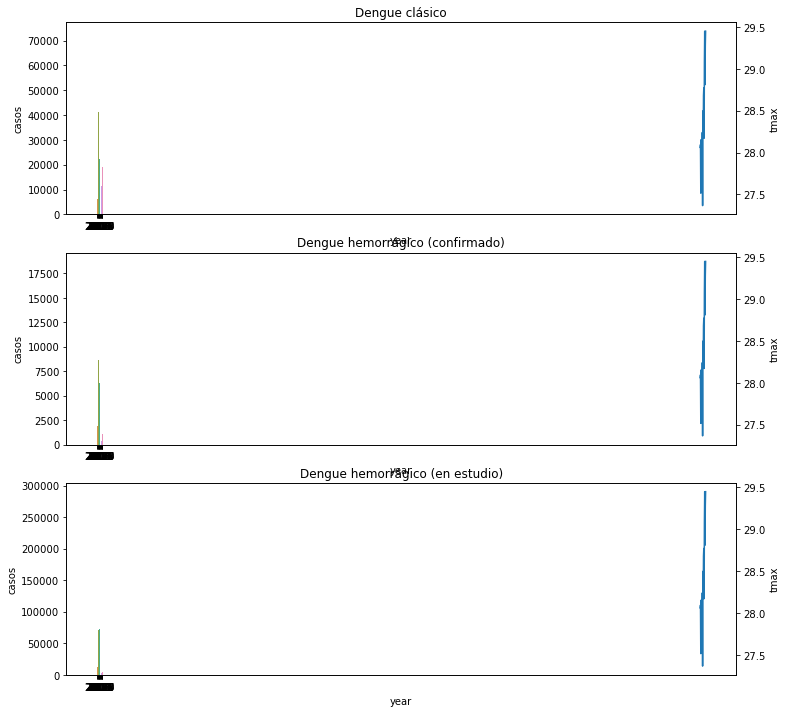

In [153]:
fig, ax = plt.subplots(nrows=3,figsize=(12,12))

i = 0
for clas, clas_df, in dfbarplornacionalgral.groupby("clase"):

    ax2 = ax[i].twinx()
    sns.barplot(x="year", y="casos", data=clas_df, ax=ax[i])

    sns.lineplot(x="year", y="tmax", data=clas_df, ax=ax2)
    ax[i].set(
        title=clas
    )
    i+=1

plt.show()

In [152]:
clas_df

,year,clase,casos,week,week_index,tmax,tmin,CVE_ENT
2,2002,Dengue hemorrágico (en estudio),2853,44096,26.5,28.061898,12.847563,16.5
5,2003,Dengue hemorrágico (en estudio),2022,44096,26.5,28.094811,12.955168,16.5
8,2004,Dengue hemorrágico (en estudio),12067,44096,27.0,27.515211,12.634318,16.5
11,2005,Dengue hemorrágico (en estudio),17210,44096,27.0,28.153861,12.843293,16.5
14,2006,Dengue hemorrágico (en estudio),27902,44096,26.5,28.116203,12.887324,16.5
17,2007,Dengue hemorrágico (en estudio),71425,44096,26.5,27.874555,12.929999,16.5
20,2008,Dengue hemorrágico (en estudio),59660,44096,26.5,27.856541,12.567943,16.5
23,2009,Dengue hemorrágico (en estudio),289873,44096,27.0,28.240530,12.909317,16.5
26,2010,Dengue hemorrágico (en estudio),72738,44096,27.0,27.366258,12.147127,16.5
29,2011,Dengue hemorrágico (en estudio),33006,44096,26.5,28.497400,12.632104,16.5


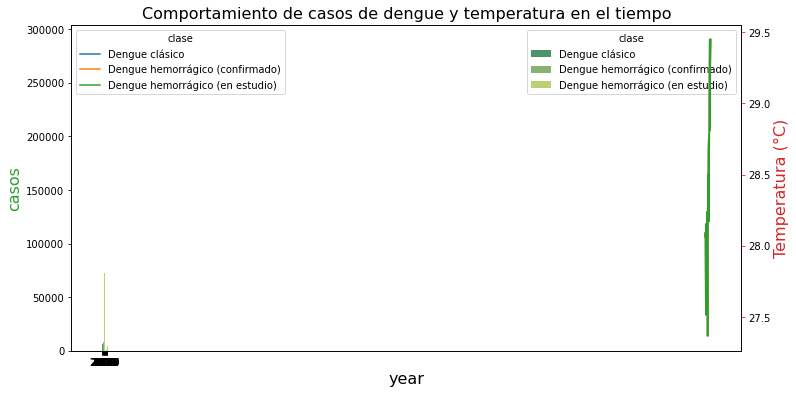

In [149]:
fig, ax1 = plt.subplots(figsize=(12,6))
color = 'tab:green'
ax1.set_title('Comportamiento de casos de dengue y temperatura en el tiempo', fontsize=16)
ax1.set_xlabel('Año', fontsize=16)
ax1.set_ylabel('Casos', fontsize=16, color=color)

ax1 = sns.barplot(x='year', y='casos', data = dfbarplornacionalgral, palette='summer', hue="clase")

ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperatura (°C)', fontsize=16, color=color)
ax2 = sns.lineplot(x='year', y='tmax', data = dfbarplornacionalgral, sort=False, color=color, hue="clase")
ax2.tick_params(axis='y', color=color)
plt.show()

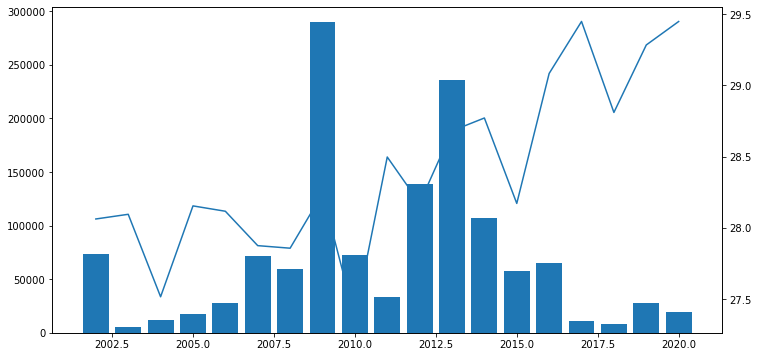

In [141]:
fig, ax = plt.subplots(figsize=(12,6))


ax.bar(dfbarplornacionalgral.year, dfbarplornacionalgral.casos)
ax2 = ax.twinx()
ax2.plot(dfbarplornacionalgral.year, dfbarplornacionalgral.tmax)



plt.show()

### Datos promedios semanales

In [74]:
denguenacionalsemanal = dfDengue.groupby(by=["week", "clase"], as_index=False).mean()
denguenacionalsemanal.head()

,week,clase,casos
0,1,Dengue clásico,4.379310
1,1,Dengue hemorrágico (confirmado),2.250000
2,1,Dengue hemorrágico (en estudio),6.368932
3,2,Dengue clásico,6.308725
4,2,Dengue hemorrágico (confirmado),4.228916


NameError: name 'denguenacionalsemanal' is not defined

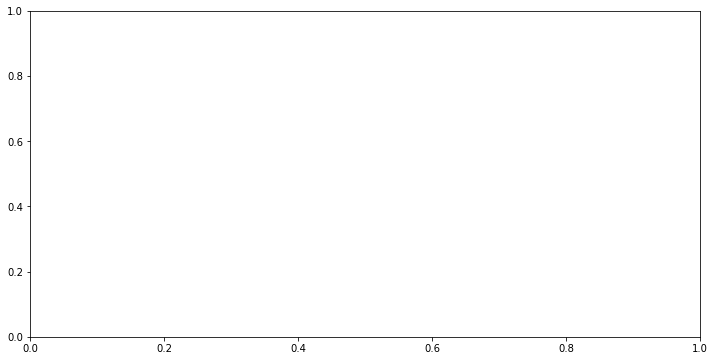

In [120]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x="week", y="casos", data=denguenacionalsemanal, hue="clase", ax=ax)
ax.set(
    title ="Casos promedio nacionales de dengue por semana",
    ylabel="Casos promedio por semana"
)
plt.show()

### Boxplots casos pais

In [78]:
dfDengue.head()

,estado,year,semana,casos,clase,week,date
3,Campeche,2002,clas_1,3.0,Dengue clásico,1,2002-01-07 00:00:00
6,Chiapas,2002,clas_1,4.0,Dengue clásico,1,2002-01-07 00:00:00
19,Oaxaca,2002,clas_1,2.0,Dengue clásico,1,2002-01-07 00:00:00
29,Veracruz,2002,clas_1,48.0,Dengue clásico,1,2002-01-07 00:00:00
30,Yucatán,2002,clas_1,1.0,Dengue clásico,1,2002-01-07 00:00:00


In [91]:
casos_P_estado = dfDengue.groupby(by=["estado"], as_index=False).sum()
casos_P_estado.sort_values("casos", ascending=False, inplace=True)
casos_P_estado = casos_P_estado.estado
casos_P_estado

29               Veracruz
17                Nayarit
14                Jalisco
12               Guerrero
22           Quintana Roo
16                Morelos
7                  Colima
24                Sinaloa
19                 Oaxaca
30                Yucatán
4                 Chiapas
27             Tamaulipas
26                Tabasco
18             Nuevo León
15              Michoacán
25                 Sonora
3                Campeche
2     Baja California Sur
23        San Luis Potosí
20                 Puebla
13                Hidalgo
6                Coahuila
10       Estado de México
11             Guanajuato
9                 Durango
31              Zacatecas
21              Querétaro
1         Baja California
5               Chihuahua
28               Tlaxcala
8        Distrito Federal
0          Aguascalientes
Name: estado, dtype: object

In [94]:
casos_P_estado[:10]

29        Veracruz
17         Nayarit
14         Jalisco
12        Guerrero
22    Quintana Roo
16         Morelos
7           Colima
24         Sinaloa
19          Oaxaca
30         Yucatán
Name: estado, dtype: object

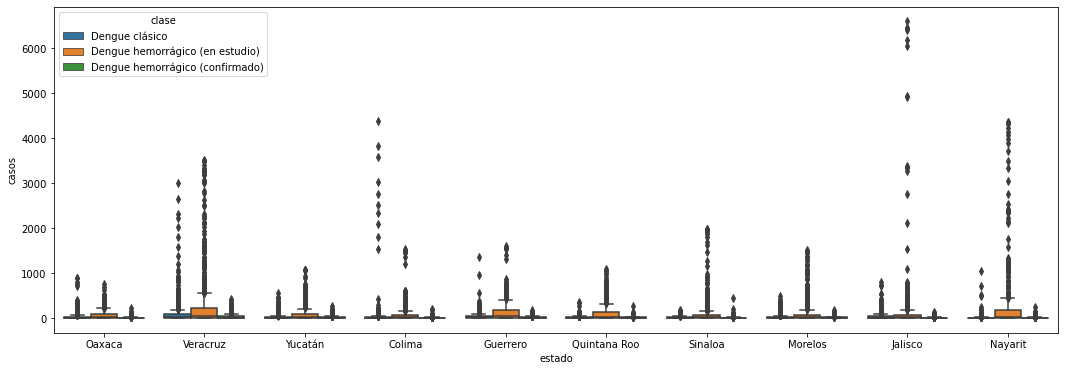

In [95]:
fig, ax = plt.subplots(figsize=(18,6))

sns.boxplot(x ="estado", y="casos", data=dfDengue[dfDengue["estado"].isin(casos_P_estado[:10])], hue="clase", ax=ax)
plt.show()

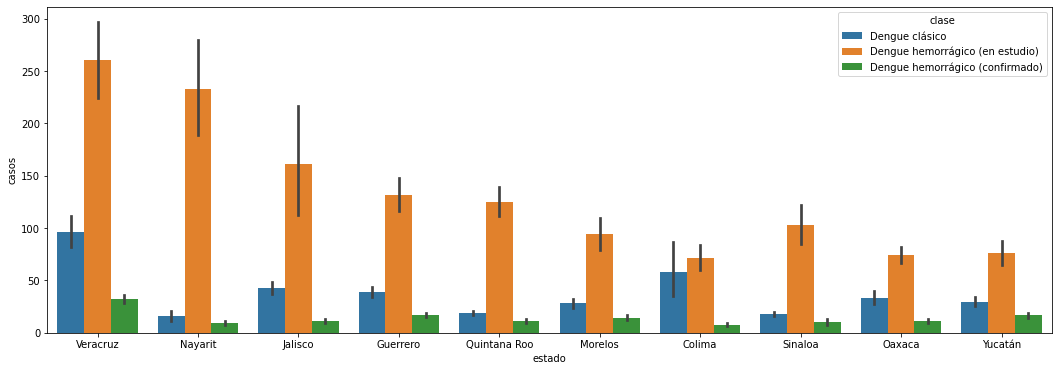

In [97]:
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(x ="estado", y="casos", data=dfDengue[dfDengue["estado"].isin(casos_P_estado[:10])], hue="clase", ax=ax, order=casos_P_estado[:10])
plt.show()